# Airbus Ship Detection Challenge
> Find ships on satellite images as quickly as possible

## Overview
해양 교통량이 점점 늘어남에 따라 예상치 못한 충돌에 휘말릴 가능성도 높아지고 있다고 주최측은 이야기 하고 있습니다.
따라서 **위성사진을 보고 모든 배를 탐지할 수 있는가?** 가 이번 대회의 목표인 것 같은데 **예상되는 방해요소**는 배를 따라가는 <u>물결 잔상, 구름, 안개 등 환경적인 요소</u>일 것 같습니다.

## Evaluation
This competition is evaluated on the F2 Score at different intersection over union  IOU thresholds.

## Data
> ※ 주의!  
현재 제공되는 데이터와 NoteBook에서 쓰이는 데이터 및 코드는 다음과 같은 차이가 있음을 발견했습니다.:
- 데이터 파일 명 및 폴더 명 뒤에 ㅇㅇ_v2가 붙습니다. (Ex. train 폴더 → train_v2 폴더)
- train_ship_segmentations의 ImageId에 해당되는 사진이 train_v2에 없음을 확인
- skimage 

Description에 나와있는 대로 라면,
- 한 사진에 있는 배의 개수(N): 0 ≤ N
- 사진의 크기: 서로 다름
- 사진의 장소: 바다 한가운데, 선 사진의 크기: 서로 다름
- 사진의 장소: 바다 한가운데, 정박하는 곳 등

언급된 바로는 object overlap정도 사진의 크기: 서로 다름
- 사진의 장소: 바다 한가운데, 선 사진의 크기: 서로 다름
- 사진의 장소: 바다 한가운데, 정박하는 곳 등
- overlap유무: 거의 없음 (있더라도 같은 방향 사진의 크기: 서로 다름
- 사진의 장소: 바다 한가운데, 정박하는 곳 등
- overlap유무: 거의 없음

※ 언급된 바로는 object overlap 조절은 크게 채점 결과에 영향을 미치지 않을 것이라고 하네요

제공되는 Data 설명:
> - `train_ship_segmentations.csv` : 지상 실측 정보 (RLE)
- `The sample_submission`: test 이미지에 있는 이미지를 포함하고 있음.

[RLE](https://stackabuse.com/run-length-encoding/)에 대한 개념을 몰라서 잠시 
짚고 넘어 가겠습니다.
**Run-Length Encoding(RLE)**이란, 입력으로 주어진 데이터 흐름함하고 있음.

[RLE](https://stackabuse.com/run-length-encoding/)에 대한 개념을 몰라서 잠시 
짚고 넘어 가겠습니다.
**Run-Length Encoding(RLE)**이란, **입력으로 주어진 데이터 흐름대로 압축된 아주 단순한 형태의 데이터**라고 합니다.  
예를 들어,
```
AAAAAAFDDCCCCCCCAEEEEEEEEEEEEEEEEE
```
이런 데이터를 RLE형태의 데이터로 encoding 한다면
```
6A1F2D7C1A17E
```
이런 식으로 표현되는 방식입니다. (예시로 든 데이터의 경우 34글자 → 13글자로 압축됨)

따라서 만약 RLE형식의 데이터를 decode하고 싶다면 다음의 함수를 생성하여 사용하면 됩니다.
```python
# rle-decode.py

def rle_decode(data):
    decode = ''
    count = ''
    for char in data:
        # If the character is numerical...
        if char.isdigit():
            # ...append it to our count
            count += char
        else:
            # Otherwise we've seen a non-numerical
            # character and need to expand it for
            # the decoding
            decode += char * int(count)
            count = ''
    return decode
```




## EDA
이번에 EDA를 위해 고른 NoteBook의 기준은 선명한 사진을 출력한 것에 있습니다.  
아무래도 사진에서 물체를 탐지하는 대회이다 보니 직접 사진을 보면서 하는 것이 흥미로울 것 같아 가장 득표수를 많이 받은 [EZ님의 Notebook](https://www.kaggle.com/ezietsman/airbus-eda)을 참고하였습니다.

### 환경설정

In [2]:
# [google Colab 환경 설정]
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path # 파일시스템 경로를 단순한 문자열이 아니라 객체로 다룸

In [4]:
import os

file_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle_Study/input/airbus-ship-detection/'

In [5]:
os.listdir(file_path)

['sample_submission_v2.csv',
 'train_ship_segmentations_v2.csv',
 'test_v2',
 'train_v2']

In [6]:
''' # ※ 디렉토리 내 전체파일 읽기 (하지 마셈 - 너무 많음)
for root, dirs, files in os.walk(file_path):
    for fname in files:
        full_fname = os.path.join(root, fname)

        print(full_fname)
'''

' # ※ 디렉토리 내 전체파일 읽기 (하지 마셈 - 너무 많음)\nfor root, dirs, files in os.walk(file_path):\n    for fname in files:\n        full_fname = os.path.join(root, fname)\n\n        print(full_fname)\n'

ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [6]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

### 데이터 불러오기

In [7]:
train = pd.read_csv(file_path + 'train_ship_segmentations_v2.csv')
train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [41]:
# train.describe()
train.shape

(231723, 2)

※ 참고로 [파이썬에서 ~(Tilde)의 역할](https://osh88itopia.tistory.com/66)은 pandas DataFrame객체에선 SQL의 'not'과 같다고 보시면 됩니다.

따라서 밑에 `sample`은 EncodedPixels의 해당 값이 NA가 아닌 값 중 25개의 train sample인 셈이죠.

그런데 **문제**가 발생했습니다. 다음과 같이 train에는 imageId가 존재하는 데 train_v2폴더에는 해당 파일이 없는 경우가 있었습니다.

In [38]:
print(train['ImageId'].isin(['d37251783.jpg']))
print(os.path.isfile(file_path + 'train_v2/d37251783.jpg'))

              ImageId                                      EncodedPixels
191217  d37251783.jpg  311000 1 311766 3 312532 6 313298 8 314064 11 ...
191218  d37251783.jpg  237129 1 237896 3 238663 5 239430 7 240197 9 2...
191219  d37251783.jpg  356347 1 357114 3 357882 5 358649 7 359416 9 3...
191220  d37251783.jpg  96443 4 97207 8 97975 8 98744 8 99512 8 100280...
191221  d37251783.jpg  292557 1 293323 4 294090 5 294856 8 295623 10 ...
191222  d37251783.jpg  327132 2 327898 4 328663 8 329428 11 330194 13...
191223  d37251783.jpg  109485 1 110252 4 111020 5 111787 8 112554 10 ...
191224  d37251783.jpg  332517 1 333283 4 334049 6 334818 6 335586 6 3...
191225  d37251783.jpg  264091 1 264858 4 265626 5 266393 8 267160 10 ...
False


따라서, 사진이 없으면 확인이 불가능 하므로 사진파일이 있는 train data만 취급해야 될 것 같습니다.

In [47]:
jpg_list = os.listdir(file_path + 'train_v2')
'''
path = Path(file_path + 'train_v2') / '{}'.format(imgid)
jpg_list = os.listdir(path)
'''

train = train[train["ImageId"].isin(jpg_list)]

한번 무작위로 사진을 확인해 보겠습니다.

먼저 **배가 있는 사진 25장** 입니다. (배가 있으면 EncodedPixels가 하나라도 있으면 됩니다.)

In [48]:
sample = train[~train.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path(file_path + 'train_v2') / '{}'.format(imgid)
    img = io.imread(path)
    
    ax[row, col].imshow(img)

Output hidden; open in https://colab.research.google.com to view.

다음으로 **배가 없는 사진 25장** 입니다. (배가 있으면 EncodedPixels가 NA이면 됩니다.)

In [49]:
sample = train[train.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path(file_path + 'train_v2') / '{}'.format(imgid)
    img = io.imread(path)
    
    ax[row, col].imshow(img)

Output hidden; open in https://colab.research.google.com to view.

그렇다면 배가 있는 사진들과, 없는 사진들의 전체적인 비율은 어떻게 될지 살펴봅시다.

(※ train에 중복된 imageId도 있어 unique() 필수)

- 배가 없는 사진이 있는 사진보다 3배 이상 많다는 것을 볼 수 
있습니다.

Ships: 22.07 %
No ships: 77.93 %


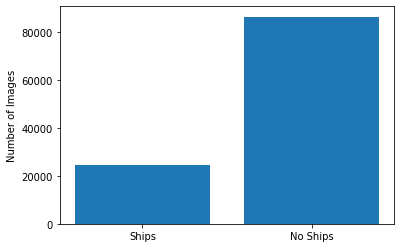

In [60]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

print('Ships:', round(len(ships) / (len(ships) + len(noships)) * 100, 2), '%')
print('No ships:', round(len(noships) / (len(ships) + len(noships)) * 100, 2), '%')

#### 사진의 색깔 분포
배가 있는 사진과 없는 사진의 사진 색깔 분포도 확인해 봅시다.

In [66]:
def get_img(imgid):
    '''Return image array, given ID.'''
    path = Path(file_path + 'train_v2/') / '{}'.format(imgid)
    return io.imread(path)

In [ ]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = np.array([get_img(_id) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)